##  Congratulations, you are now hired as a sport analytic. Your job is to give prediciton for the next Mathball tournament of the Six finest mathematicians in the world, which is a competition between Laplace, Gauss, Newton, Euler, Leibniz, Von-Neumann.

## The mathball is just like football where a player a goal is legal only after scoring you answer correctly a math question. 

## Motivation:  
### We want to infer a latent parameter - that is the 'strength' of a mathematician based only on their **scoring intensity**, and all we have are their scores and results, we can't accurately measure the 'strength' of a team.


In [3]:
# imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pickle as pkl

## The input   looks like as follows: 

In [4]:
group = 1
df_all  = pkl.load(open('../data_mathball/mathball_data_group_' + str(group)+ '.pkl', 'rb'))
df_all.head()

,home_player,away_player,home_score,away_score,year
0,Leibniz,Gauss,20,22,1897
1,Leibniz,Laplace,30,10,1897
2,Euler,Von-Neumann,29,18,1897
3,Newton,Euler,0,20,1897
4,Gauss,Newton,29,6,1897


## We have home and away team, we have score and year. 

## What do we want to infer?

### We want to infer the latent parameters (every mathematian's strength) that are generating the data we observe (the scorelines).
### Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.

## What do we want?

### We want to quantify our uncertainty
### We want to also use this to generate a model
### We want the answers as distributions not point estimates

## Part 1

### We next do some exploratory data analysis. The idea is to get a general sense of what is going on.

## Tasks

### 1. Plot a bar chart of the goal difference (i.e., total scored minus total scored against) per mathematician. Who is the best mathematician and who is the worst according to this plot?
### 2. Plot the same bar chart for each mathematician  as a function of time. Do you see a monote behvaoir which implies an improvement or the other way around for one of mathematician?
### 3. Choose your favorite mathematician, compare the goal difference between home and away games. Is he better in home or away games? Plot a bar chart of the goal difference for both home and away games.
### 4. Which mathematician has the best median away results? (that is, for each mathematician go over all of his away games, compute his scoring difference (how much he scored minues got scored against) and compute the median value). 

## Part 2

## What assumptions do we know for our mathball competition?

### We know that there are 6 mathematicians, each year all possible pairs playes once.  
### We have data from the last few years
### We also know that in sports scoring is modelled as a Poisson distribution (even in mathball)
### We consider home advantage to be a strong effect in sports 

## The model.

### The league is made up by a total of T= 6 mathematicians, playing each other once in a season.

### We indicate the number of goals scored by the home and the away player in the g-th game of the season (15 games) as $y_{g1}$ and $y_{g2}$ respectively. </p>
### The vector of observed goal counts $\mathbb{y} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:
## $$y_{gj}| \theta_{gj} \tilde\;\;  Poisson(\theta_{gj})$$
### where the theta parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>

## We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
### $$ log \theta_{g1} = intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)} $$
### $$ log \theta_{g2} = intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}$$


## Alternitevly: 

### $$  \theta_{g1} = e^{intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)}} $$
### $$  \theta_{g2} = e^{intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}}$$

### $\hat{att}_{h(g)}$ is the attack effect of a player. 
### $\hat{def}_{h(g)}$ is the attack effect of a player. 

### For mathematician  i = 1, ..., 6, both  $\hat{att}_{i}$ and $\hat{def}_{i}$ are normalized values, fomrally:

### $$ \hat{att}_{i} = att_i - \bar{att} $$
### $$ \hat{def}_{i} = att_i - \bar{def} $$

where, 

### $$ \bar{att}  = \frac{\sum_{i=1}^6 att_i}{6} $$
### $$ \bar{def}  = \frac{\sum_{i=1}^6 def_i}{6} $$

### Just for clarification: suppose we index mathematicians as follows:
### 1: Laplace
### 2: Gauss
### 3: Newton
### 4: Euler
### 5: Leibniz
### 6: Von-Neumann

### Now, suppose the first game is Laplace hosting Gauss (the clash of the titans).
### Thus, $h(1) = 1 $ (i.e.,Laplace ) and $a(1) = 2 $ (i.e., Gauss). 

### The parameter home represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season
### The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters att and def, respectively

### Conversely, for each i = 1, ..., 6, the player-specific effects are modelled as exchangeable from a common distribution:

### $att_{i} \; \tilde\;\; Normal(0,\tau_{att})$ and $def_{i} \; \tilde\;\;Normal(0,\tau_{def})$

### The log function to away scores and home scores is a standard trick in the sports analytics literature

## Tasks

### 1. Build a Hierarchical model with PyMc where you obtain a posterior of the latent variables: $home$, $att_i$,  $def_i$ for $i = \{1,2,3,4,5,6\} $ and $intercept$. 
### Remark: Set the MCMC configuration regarding the number of draws, such that there will 4000 samples in total.



## guidence: 
###  For the Hierarchical model, connect the different players (mathematicians) only via the attack and defence std (i.e., $\tau_{att}$ and $\tau_{def}$) and not the mean value. 

## Indexing the data for the pymc model

In [12]:
import numpy as np

In [10]:
df_all.head()

,home_player,away_player,home_score,away_score,year
0,Leibniz,Gauss,20,22,1897
1,Leibniz,Laplace,30,10,1897
2,Euler,Von-Neumann,29,18,1897
3,Newton,Euler,0,20,1897
4,Gauss,Newton,29,6,1897


In [5]:
## for your convinience we have here the home and away index with respect to df_all.
home_idx, teams = pd.factorize(df_all["home_player"], sort=True)
away_idx, _ = pd.factorize(df_all["away_player"], sort=True)


In [20]:
df_all.head()

,home_player,away_player,home_score,away_score,year
0,Leibniz,Gauss,20,22,1897
1,Leibniz,Laplace,30,10,1897
2,Euler,Von-Neumann,29,18,1897
3,Newton,Euler,0,20,1897
4,Gauss,Newton,29,6,1897


In [22]:
home_idx

array([3, 3, 0, 4, 1, 1, 2, 5, 0, 5, 1, 5, 3, 2, 4, 4, 3, 2, 4, 3, 0, 5,
       2, 4, 1, 5, 0, 2, 1, 0, 1, 1, 3, 0, 3, 2, 5, 3, 2, 5, 0, 4, 5, 4,
       1, 4, 5, 5, 0, 0, 1, 2, 4, 2, 2, 3, 4, 3, 0, 1], dtype=int64)

In [ ]:
coords = {"team": teams, 'home_idx': home_idx, 'away_idx': away_idx}

with pm.Model(coords=coords) as mathball:

    # Hyperpriors
    tau_att = # your code here
    tau_def = # your code here

    # Priors
    intercept = #
    home = #
    att = pm.Normal('att', mu=0, sigma=tau_att, dims="team")
    def_ = pm.Normal('def', mu=0, sigma=tau_def, dims="team")

    ## att_centered function: substracting the mean att using pm.math.mean (your code here)
    ## att_centered function: substracting the mean def using pm.math.mean (your code here)
    
    # Rate models
    ## rate home function: intercept  + home +  att_centered[home_indx] + def_centered[away_idx] (your code here)
    ## rate home function: intercept  +  att_centered[away_idx] + def_centered[home_indx] (your code here)

    theta_g1 = # exponent funciton home games (your code here)
    theta_g2 = # exponent funciton away games (your code here)

    # Data likelihood
    y1_likelihood = # Likelihood home score a function theta_g1 - Poisson (your code here) 
    y2_likelihood = # Likelihood home score  function theta_g2 - Poisson  (your code here) a function thetag2

    ## pm.sample(your code here)

In [8]:
teams

Index(['Euler', 'Gauss', 'Laplace', 'Leibniz', 'Newton', 'Von-Neumann'], dtype='object')

In [9]:
away_idx

array([1, 2, 5, 0, 4, 5, 4, 4, 1, 2, 2, 3, 0, 0, 3, 1, 5, 5, 5, 4, 4, 1,
       3, 2, 0, 0, 2, 1, 3, 3, 5, 2, 0, 5, 2, 4, 2, 1, 0, 3, 1, 0, 4, 3,
       4, 5, 0, 1, 4, 2, 0, 5, 1, 1, 3, 4, 2, 5, 3, 3], dtype=int64)

In [26]:
df_all.head(7)

,home_player,away_player,home_score,away_score,year
0,Leibniz,Gauss,20,22,2014
1,Leibniz,Laplace,30,10,2014
2,Euler,Von-Neumann,29,18,2014
3,Newton,Euler,0,20,2014
4,Gauss,Newton,29,6,2014
5,Gauss,Von-Neumann,27,3,2014
6,Laplace,Newton,20,21,2014


## Your code in here

## Part 3

## We aim to understand the different distributions of attacking strength and defensive strength.
## These are probabilistic estimates and help us better understand the uncertainty in sports analytics.

## Tasks

### 1. Plot the attack and defence strenght HDI for each team and compare them. Which player has the best offence and which has the best defence? who has the worst offence and defence? Does these results is aligned with part 1 analysis?
### 2. What is the probability that Euler has a better defence than Gauss? 
### 3. Suppose Leibniz is hosting Newton for a game. What is the probability that Leibniz will score more than 20? what is the probability that Newton will score less than 20?

### 4. Simulate who wins over a total of 4000 simulations, one per sample in the posterior. Hint: use the sample_posterior_predictive function.
### The resulting simulation should give you the score per each game for all possible combinations for 4 seasons. For each sample out of the 4000 we can measure who will be ranked 1st, 2nd, etc. The ranking is done as follows: 
### If a player wins he gets 3 points, draw a single point and lost 0 points. Sum up the points and you will get a full ranking. If we aggregate the results, we can the probability for each player for each position. 

### You are required to draw a bar chart that indicates the probability of all possible ranks for each team.


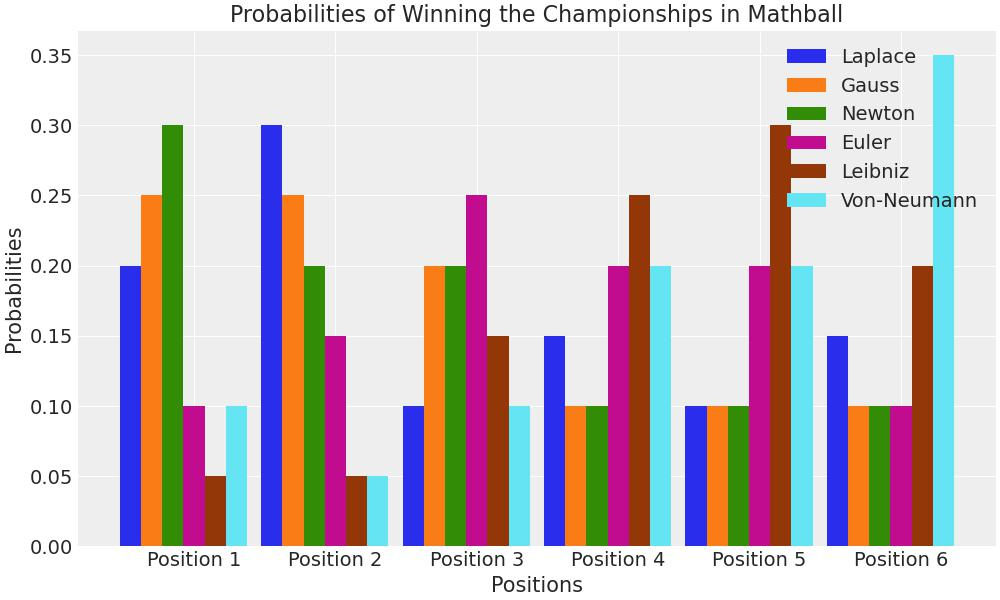

In [7]:
from IPython.display import Image, display
image_path = 'img_bar_chat.jpg'
display(Image(filename=image_path))

## Your code and answers here